# Successful examples of using Dynamic mode decomposition on PDE system 

We apply dynamic mode decomposition (DMD) to several PDE systems from J. Nathan Kutz,
J. L. Proctor, and S. L. Brunton,
“Applied Koopman Theory for Partial Differential Equations and Data-Driven
Modeling of Spatio-Temporal Systems,” Complexity, vol. 2018, no. ii, pp. 1–16, 2018.): 1) 1D viscous Burgers equation. 2) 1D nonlinear schrodinger equation


In these two examples, DMD works because the inherent dynamics is both low rank and linear.

We first import the pyKoopman package and other packages for plotting and matrix manipulation.

In [1]:
import sys
sys.path.append('../src')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

import pykoopman as pk

## 1. Viscous Burgers equation

$$
u_t + u u_x = \nu u_{xx}
$$
where periodic boundary condition is used on $[-15,15]$. Initial condition follows 
$u(x,0)=e^{-(x+2)^2}$.

- use `vbe.simulate` to run simulation in order to get the training data
- use `vbe.visualize_data` to see how data evolves in space and time
- use `vbe.visualize_state_space` to see the data distribution in the first 3 PCA directions

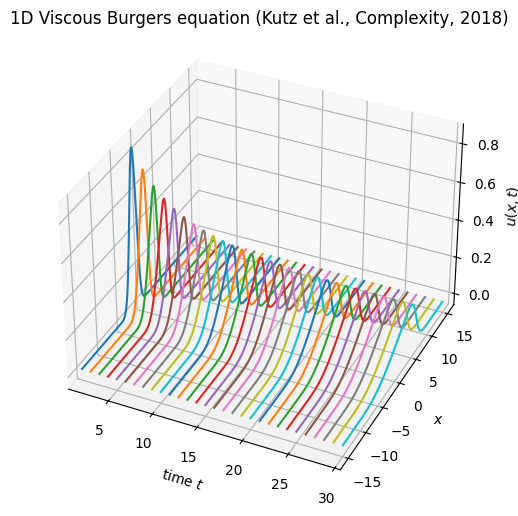

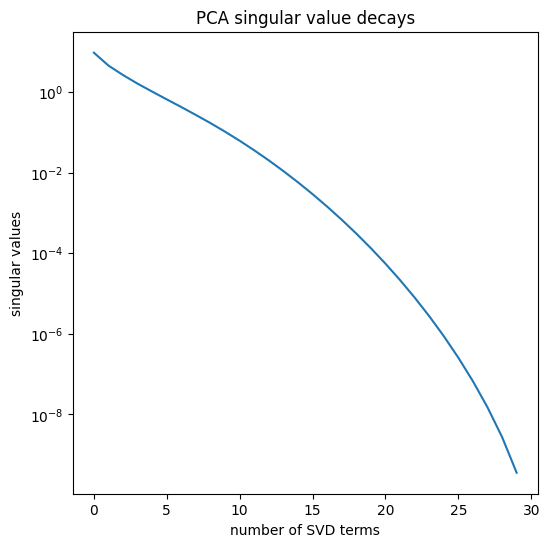

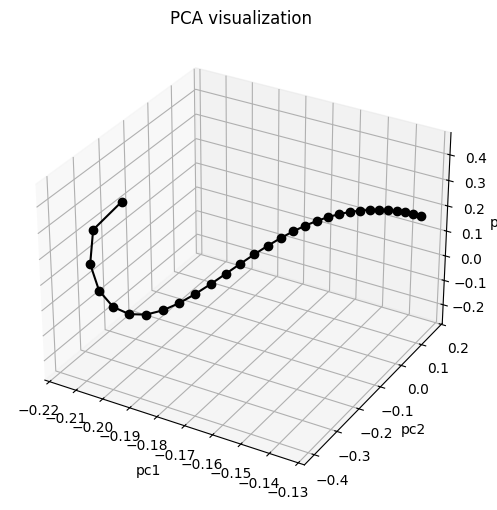

data shape =  (30, 256)


In [3]:
from pykoopman.common import vbe

n = 256
x = np.linspace(-15, 15, n, endpoint=False)
u0 = np.exp(-(x+2)**2)
# u0 = 2.0 / np.cosh(x)
# u0 = u0.reshape(-1,1)
n_int = 3000
n_snapshot = 30
dt = 30. / n_int
n_sample = n_int // n_snapshot

model_vbe = vbe(n, x, dt=dt, L=30)
X, t = model_vbe.simulate(u0, n_int, n_sample)
delta_t = t[1]-t[0]

model_vbe.visualize_data(x, t, X)
model_vbe.visualize_state_space(X)

print("data shape = ",X.shape)

Run a vanilla DMD with just rank = 5. First, we import DMD regressor, feed it into `Koopman`. Second, we use `model.fit` to fit the data

In [4]:
from pydmd import DMD

dmd = DMD(svd_rank=5)
model = pk.Koopman(regressor=dmd)
model.fit(X, dt=delta_t)

Koopman(observables=Identity(),
        regressor=PyDMDRegressor(regressor=<pydmd.dmd.DMD object at 0x7567b4fc38e0>))

Check spectrum

Just use `model.koopman_matrix` to get the Koopman matrix

Text(0, 0.5, '$Im(\\lambda)$')

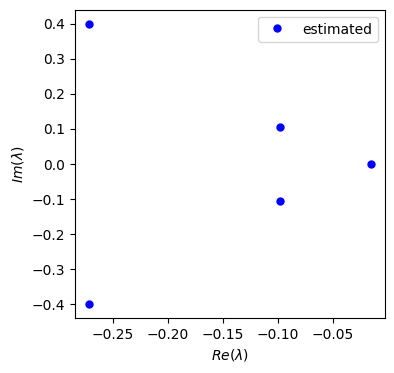

In [5]:
K = model.A

# Let's have a look at the eigenvalues of the Koopman matrix
evals, evecs = np.linalg.eig(K)
evals_cont = np.log(evals)/delta_t

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(evals_cont.real, evals_cont.imag, 'bo', label='estimated',markersize=5)


# ax.set_xlim([-0.1,1])
# ax.set_ylim([2,3])
plt.legend()
plt.xlabel(r'$Re(\lambda)$')
plt.ylabel(r'$Im(\lambda)$')
# print(omega1,omega2)

Define plotting function

In [6]:
def plot_pde_dynamics(x, t, X, X_pred, title_list, ymin=0, ymax=1):
    
    fig = plt.figure(figsize=(12, 8))
    
    ax = fig.add_subplot(131, projection='3d')
    for i in range(X.shape[0]):
        if X.dtype != 'complex':
            ax.plot(x, X[i], zs=t[i], zdir='t')
        else:
            ax.plot(x, abs(X[i]), zs=t[i], zdir='t')     
    ax.set_ylim([ymin, ymax])
    ax.view_init(elev=35., azim=-65, vertical_axis='y')
    if X.dtype != 'complex':
        ax.set(ylabel=r'$u(x,t)$', xlabel=r'$x$', zlabel=r'time $t$')
    else:
        ax.set(ylabel=r'mag. of $u(x,t)$', xlabel=r'$x$', zlabel=r'time $t$')
        
    plt.title(title_list[0])

    ax = fig.add_subplot(132, projection='3d')
    for i in range(X.shape[0]):
        if X.dtype != 'complex':
            ax.plot(x, X_pred[i], zs=t[i], zdir='t')
        else:
            ax.plot(x, abs(X_pred[i]), zs=t[i], zdir='t')
    ax.set_ylim([ymin, ymax])
    ax.view_init(elev=35., azim=-65, vertical_axis='y')
    if X.dtype != 'complex':
        ax.set(ylabel=r'$u(x,t)$', xlabel=r'$x$', zlabel=r'time $t$')
    else:
        ax.set(ylabel=r'mag. of $u(x,t)$', xlabel=r'$x$', zlabel=r'time $t$')
    plt.title(title_list[1])
    
    ax = fig.add_subplot(133, projection='3d')
    for i in range(X.shape[0]):
        if X.dtype != 'complex':
            ax.plot(x, X_pred[i]-X[i], zs=t[i], zdir='t')
        else:
            ax.plot(x, abs(X_pred[i]-X[i]), zs=t[i], zdir='t')
    ax.set_ylim([ymin, ymax])
    ax.view_init(elev=35., azim=-65, vertical_axis='y')
    if X.dtype != 'complex':
        ax.set(ylabel=r'$u(x,t)$', xlabel=r'$x$', zlabel=r'time $t$')
    else:
        ax.set(ylabel=r'mag. of $u(x,t)$', xlabel=r'$x$', zlabel=r'time $t$')
    plt.title(title_list[2])

run inference using `model.simulate`

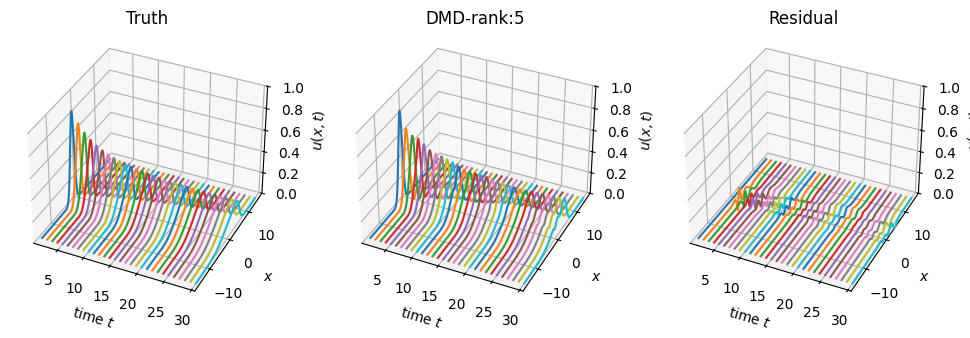

In [7]:
X_predicted = np.vstack((X[0], model.simulate(X[0], n_steps=X.shape[0] - 1)))
plot_pde_dynamics(x,t,X, X_predicted, ['Truth','DMD-rank:'+str(model.A.shape[0]),'Residual'])

## 2. nonlinear schrodinger equation

$$iu_t + 0.5u_{xx} + u|u|^2 = 0$$

periodic boundary condition in $[-15,15]$ with initial condition as 
$2.0 / \cosh(x)$

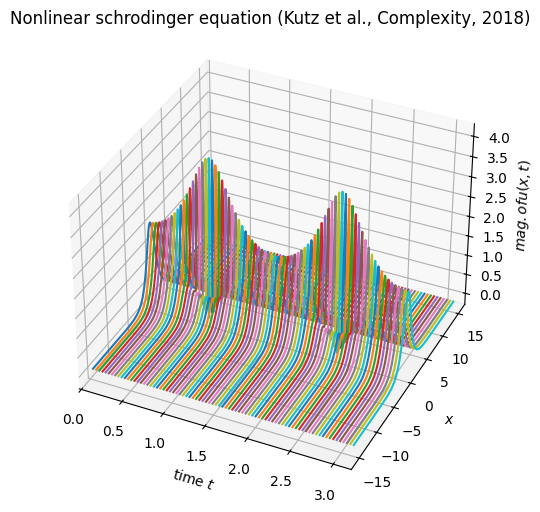

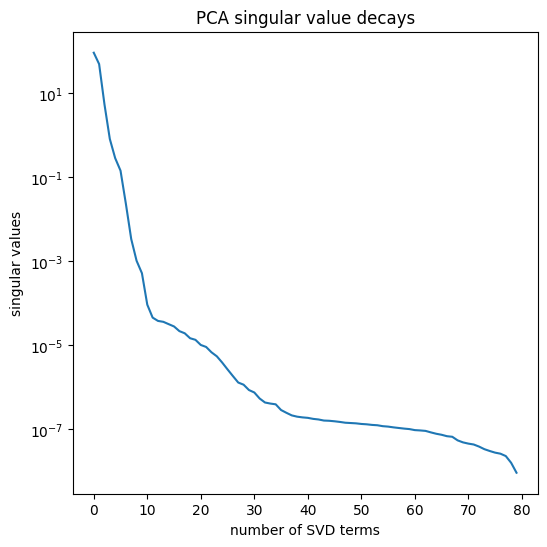

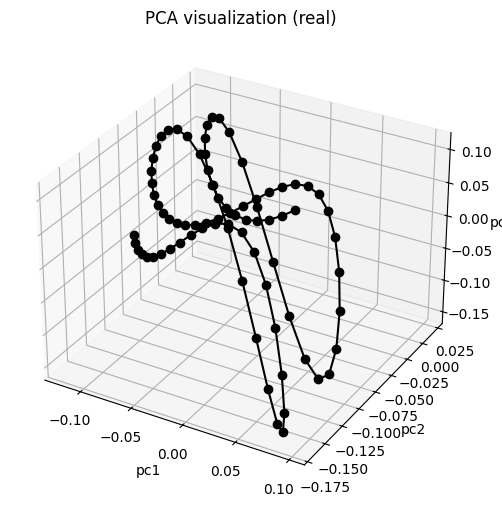

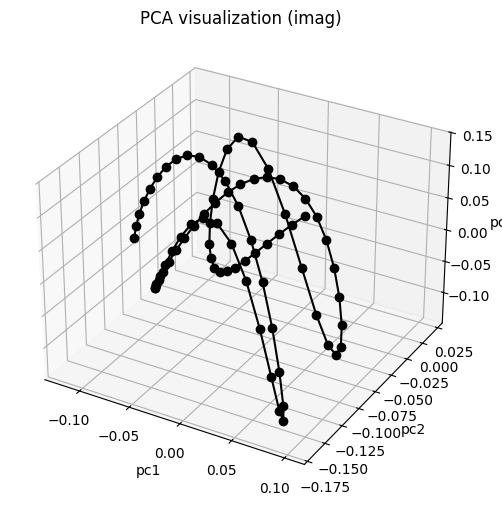

In [8]:
from pykoopman.common import nlse

n = 512
x = np.linspace(-15, 15, n, endpoint=False)
u0 = 2.0 / np.cosh(x)
# u0 = u0.reshape(-1,1)
n_int = 10000
n_snapshot = 80  # in the original paper, it is 20, but I think too small
dt = np.pi / n_int
n_sample = n_int // n_snapshot

model_nlse = nlse(n, dt=dt, L=30)
X, t = model_nlse.simulate(u0, n_int, n_sample)

delta_t = t[1] - t[0]

model_nlse.visualize_data(x,t,X)
model_nlse.visualize_state_space(X)

Run a vanilla DMD with rank = 10

In [9]:
from pydmd import DMD

dmd = DMD(svd_rank=10)
model = pk.Koopman(regressor=dmd)
model.fit(X, dt=delta_t)

Koopman(observables=Identity(),
        regressor=PyDMDRegressor(regressor=<pydmd.dmd.DMD object at 0x7567a2960be0>))

Text(0, 0.5, '$Im(\\lambda)$')

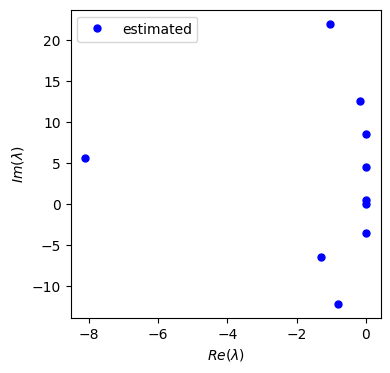

In [10]:
K = model.A

# Let's have a look at the eigenvalues of the Koopman matrix
evals, evecs = np.linalg.eig(K)
evals_cont = np.log(evals)/delta_t

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(evals_cont.real, evals_cont.imag, 'bo', label='estimated',markersize=5)


# ax.set_xlim([-0.1,1])
# ax.set_ylim([2,3])
plt.legend()
plt.xlabel(r'$Re(\lambda)$')
plt.ylabel(r'$Im(\lambda)$')
# print(omega1,omega2)

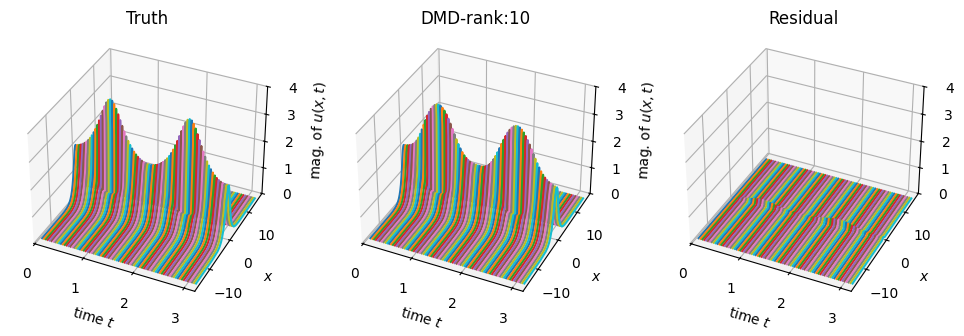

In [11]:
X_predicted = np.vstack((X[0], model.simulate(X[0], n_steps=X.shape[0] - 1)))
plot_pde_dynamics(x,t,X, X_predicted, 
                  ['Truth','DMD-rank:'+str(model.A.shape[0]),'Residual'],
                 0,4)

**Conclusion: **
- DMD works very well for both systems - a simple linear fit can leads to
visually very good reconstruction performance for nonlinear system

## 3. Revisiting cubic-quintic Ginzburg-Landau equation

Previously, we talked about a "Unsuccessful examples of using Dynamic mode decomposition on PDE system" and used an example of Ginzburg-Landau equation. In fact, we can make DMD work by simply truncating the initial transient phase. 

In [12]:
from pykoopman.common import cqgle

n = 512
x = np.linspace(-10, 10, n, endpoint=False)
u0 = np.exp(-((x) ** 2))
# u0 = 2.0 / np.cosh(x)
# u0 = u0.reshape(-1,1)
n_int = 9000
n_snapshot = 300
dt = 40.0 / n_int
n_sample = n_int // n_snapshot

model_cqgle = cqgle(n, x, dt, L=20)
X, t = model_cqgle.simulate(u0, n_int, n_sample)

Here we truncate it after 100 time units

In [13]:
X = X[100:]

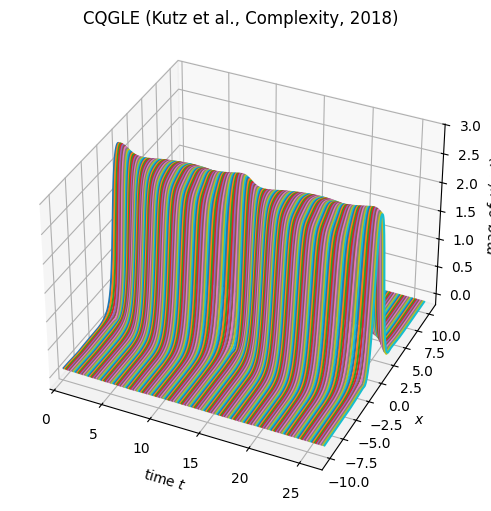

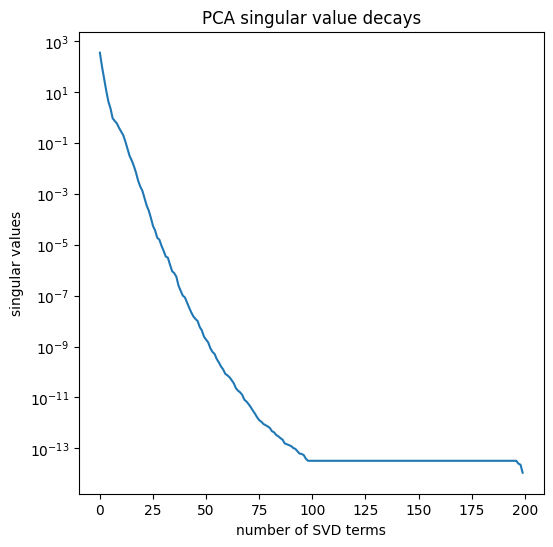

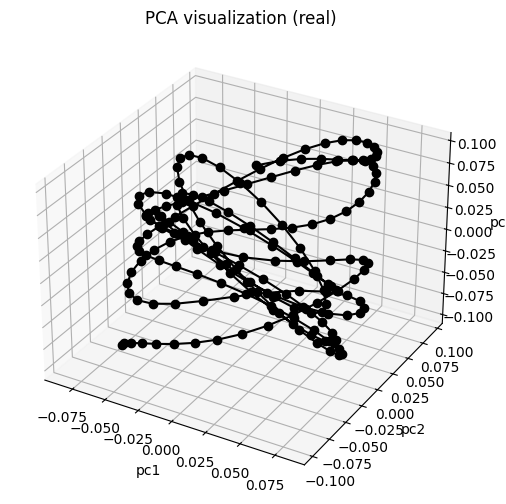

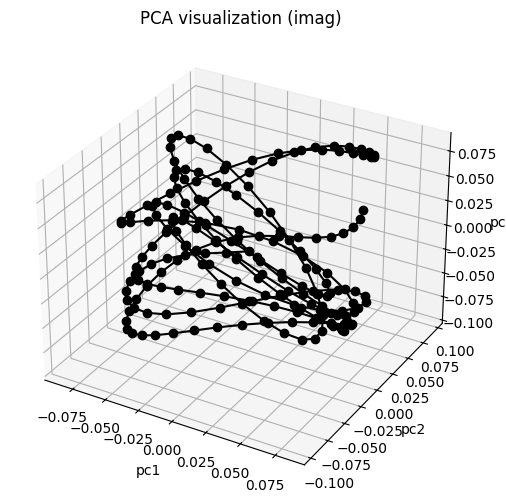

In [14]:
delta_t = t[1] - t[0]

# usage: visualize the data in physical space
model_cqgle.visualize_data(x, t, X)
model_cqgle.visualize_state_space(X)

In fact, there isn't any change to the singular spectrum. But now you will see DMD will work amazingly on this problem

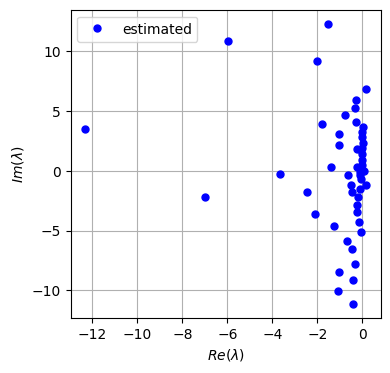

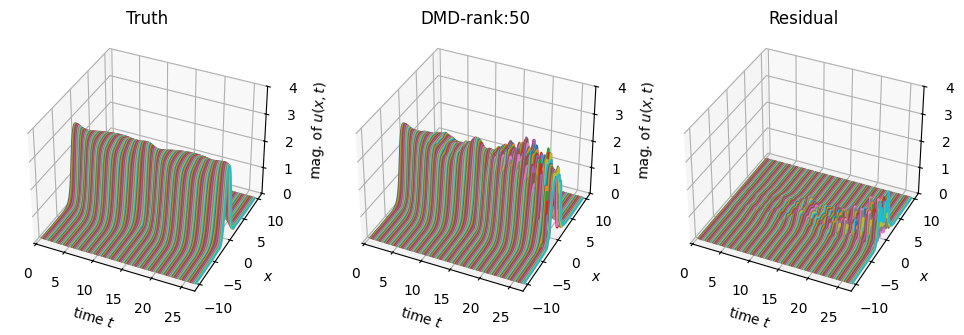

In [15]:
from pydmd import DMD

dmd = DMD(svd_rank=50)
model = pk.Koopman(regressor=dmd)
model.fit(X, dt=delta_t)

K = model.A

# Let's have a look at the eigenvalues of the Koopman matrix
evals, evecs = np.linalg.eig(K)
evals_cont = np.log(evals)/delta_t

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
# ax.plot(evals.real, evals.imag, 'bo', label='estimated', markersize=5)
ax.plot(evals_cont.real, evals_cont.imag, 'bo', label='estimated', markersize=5)
plt.legend()
plt.grid('on')
plt.xlabel(r'$Re(\lambda)$')
plt.ylabel(r'$Im(\lambda)$')

X_predicted = np.vstack((X[0], model.simulate(X[0], n_steps=X.shape[0]-1)))
plot_pde_dynamics(x, t, X, X_predicted, 
                  ['Truth','DMD-rank:'+str(model.A.shape[0]),'Residual'], 0, 4)

**Conclusion:**
- by removing some initial phase, we find vanilla DMD algorithm improves
significantly. However, this means if one can stabilize DMD for general case, the
algorith of Koopman can be much more powerful. This is the motivation for one of the
authors to pursue learning stabilized Koopman opeartor.